In [16]:
import sys

import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image
import urllib3  # self explanatory
from PIL import Image
import numpy as np
import os
import csv
import tensorflow as tf
import matplotlib.pylab as plt

In [2]:
confusion_matrix = [[0]*91 for i in range(90)]
# detector = hub.load("https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1") # WORKS dope
# detector = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1") # ALSO works dope but waaaay slower
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1") # WORKS FAAST
global_path = "C:\\Users\\wierc\\Desktop\\ml-project\\data-ml\\"

In [35]:
def predict(my_image, width=None, height=None):
    # commented for open_image_from_google
    # my_image = image.smart_resize(my_image, size=(1024, 1024))
    x = image.img_to_array(my_image)
    if width is not None and height is not None:
        x = tf.image.resize(x, [width, height], preserve_aspect_ratio=True)
    x = np.expand_dims(x, axis=0)
    preds = detector(x)
    return preds


def open_image_from_google(coco):

    # impath = "D:\\AGH\\VI semestr\\ML\\datasetGoogle\\OIDv4_ToolKit\\OID\\Dataset\\test\\Apple\\964b69442edeec04.jpg"
    impath = global_path + "OIDv4_ToolKit\\OID\\Dataset\\test\\Apple\\964b69442edeec04.jpg"

    apple = Image.open(impath)
    result, x = predict(apple)
    results = {key:value.numpy() for key,value in result.items()}
    detection_classes = results['detection_classes']
    print("model thinks: " + coco[detection_classes[0][0]])




def get_coco_labels():
    http = urllib3.PoolManager()
    r = http.request('GET', 'https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt')
    dane = r.data.decode('UTF-8')
    my_data = dane.split('\n')

    coco = {i+1: my_data[i] for i in range(0,len(my_data))}
    coco.pop(91)
    return coco



def get_downloadable_labels_str(coco):
    d = {value:1 for value in coco.values()}
    # tmp = d["street sign"]

    # nowa googlowa          stara coco
    d["traffic sign"] = d.pop("street sign")
    d["bull"] = d.pop("cow")
    d["glasses"] = d.pop("eye glasses")
    d["boot"] = d.pop("shoe")
    d["hair dryer"] = d.pop("hair drier")
    d["doughnut"] = d.pop("donut")
    d["microwave oven"] = d.pop("microwave")
    d["telephone"] = d.pop("cell phone")
    d["computer keyboard"] = d.pop("keyboard")
    d["remote control"] = d.pop("remote")
    d["computer mouse"] = d.pop("mouse")
    d["television"] = d.pop("tv")
    d["Kitchen dining room table"] = d.pop("dining table")
    d["plant"] = d.pop("potted plant")
    d["ski"] = d.pop("skis")
    d["volleyball"] = d.pop("sports ball")
    d["coffee cup"] = d.pop("cup")
    d["flying disc"] = d.pop("frisbee")
    # hairbrush
    # d.pop("hair brush")

    labels = list(d.keys())
    lb = [x.capitalize() for x in labels]
    lb1 = [label.replace(" ","_") for label in lb]
    str1 = " "
    names = str1.join(lb1)
    print(names)
    return names





def get_paths_to_photos_and_labels(dataset_path= global_path + "OIDv4_ToolKit\\OID\\Dataset\\train"):

    directory_contents = os.listdir(dataset_path)

    class_path_dict = {}

    for subdirectory in directory_contents:
        images = os.listdir(dataset_path + "\\" + subdirectory)

        for image_ in images:
            if image_.endswith(".jpg"):
                full_image_path = dataset_path + "\\" + subdirectory + "\\" + image_
                if subdirectory.lower() in class_path_dict:
                    class_path_dict[subdirectory.lower()].append(full_image_path)
                else:
                    class_path_dict[subdirectory.lower()] = [full_image_path]

    return class_path_dict


def get_all_images_metadata_dict(path= global_path + "OIDv4_ToolKit\\OID\\csv_folder\\train-annotations-bbox.csv"):
    my_dict = {}

    correct_class_id = class_id_to_coco_label_map.keys()

    with open(path, mode='r') as infile:
        reader = csv.reader(infile)
        for row in reader:
            if row[0] not in my_dict:
                if row[2] in correct_class_id:
                    my_dict[row[0]] = []
                    my_dict[row[0]].append(row[1:])
            else:
                if row[2] in correct_class_id:
                    my_dict[row[0]].append(row[1:])




    return my_dict



def get_class_id_to_open_image_label_map(path = global_path + "OIDv4_ToolKit\\OID\\csv_folder\\class-descriptions-boxable.csv"):
    f = open(path)
    class_map = {}
    for line in f:
        data_line = line.rstrip().split(',')
        class_map[data_line[0]] = data_line[1]
    return class_map


def convert_open_image_label_to_coco(class_map):

    class_map = {value.lower():key for key, value in class_map.items()}

    class_map["street sign"] = class_map.pop("traffic sign")
    class_map["cow"] = class_map.pop("bull")
    class_map["eye glasses"] = class_map.pop("glasses")
    class_map["shoe"] = class_map.pop("boot")
    class_map["hair drier"] = class_map.pop("hair dryer")
    class_map["donut"] = class_map.pop("doughnut")
    class_map["microwave"] = class_map.pop("microwave oven")
    class_map["cell phone"] = class_map.pop("telephone")
    class_map["keyboard"] = class_map.pop("computer keyboard")
    class_map["remote"] = class_map.pop("remote control")
    class_map["mouse"] = class_map.pop("computer mouse")
    class_map["tv"] = class_map.pop("television")
    class_map["dining table"] = class_map.pop("kitchen dining room table")
    class_map["potted plant"] = class_map.pop("plant")
    class_map["skis"] = class_map.pop("ski")
    class_map["sports ball"] = class_map.pop("volleyball")
    class_map["cup"] = class_map.pop("coffee cup")
    class_map["frisbee"] = class_map.pop("flying disc")
    # hairbrush

    return {value:key for key, value in class_map.items()}


def remove_non_coco_labels(class_id_to_coco_label_map):
    coco_list  = list(coco.values())
    class_id_to_only_coco_map = {}
    for key,val in class_id_to_coco_label_map.items():
        if val in coco_list:
            class_id_to_only_coco_map[key] = val

    return class_id_to_only_coco_map



def get_image_labels_with_bbox(metadata):
    labes_bboxes = []
    for entry in metadata:
        bbox = [float(i) for i in entry[3:7]]
        labes_bboxes.append([class_id_to_coco_label_map[entry[1]],bbox])

    return labes_bboxes


def predict_single_image(path= global_path + "OIDv4_ToolKit\\OID\\Dataset\\test\\Baseball glove\\0298c70279b6e842.jpg", width=None, height=None):
    image_name = os.path.basename(path).split(".")[0]
    image_ = Image.open(path)
    result = predict(image_,width,height)
    results = {key:value.numpy() for key,value in result.items()}
    return results, image_name


def compute_iou(groundtruth_box, detection_box):
    g_xmin, g_xmax, g_ymin, g_ymax = groundtruth_box
    d_ymin, d_xmin, d_ymax, d_xmax = detection_box

    xa = max(g_xmin, d_xmin)
    ya = max(g_ymin, d_ymin)
    xb = min(g_xmax, d_xmax)
    yb = min(g_ymax, d_ymax)

    intersection = max(0, xb - xa + 1) * max(0, yb - ya + 1)

    boxAArea = (g_xmax - g_xmin + 1) * (g_ymax - g_ymin + 1)
    boxBArea = (d_xmax - d_xmin + 1) * (d_ymax - d_ymin + 1)

    return intersection / float(boxAArea + boxBArea - intersection)


def update_confusion_matrix(oryginal_label_bbox, detected_label_bbox):
    if detected_label_bbox == None:
        confusion_matrix[coco_readable_to_index[oryginal_label_bbox[0]]-1][-1] += 1
    else:
        confusion_matrix[coco_readable_to_index[oryginal_label_bbox[0]]-1][coco_readable_to_index[detected_label_bbox[0]]-1] += 1



def perform_analysis(model_result, image_name):
    image_metadata_list = all_images_metadata_dict[image_name]
    labels_bboxes_original = get_image_labels_with_bbox(image_metadata_list)


    detected_classes = model_result['detection_classes'][0]
    detected_classes_accuracy = model_result['detection_scores'][0]
    detected_classes_bboxes = model_result['detection_boxes'][0]

    labels_bboxes_detected = []
    for d_class, score, bbox in zip(detected_classes,detected_classes_accuracy, detected_classes_bboxes):
        if score >= 0.5:
            labels_bboxes_detected.append([coco[d_class], list(bbox)])


    for bbox_oryginal in labels_bboxes_original:
        tmp = []
        best_detected_bbox = None
        for bbox_detected in labels_bboxes_detected:
            iou = compute_iou(bbox_oryginal[1], bbox_detected[1])
            if iou >= 0.5:
                tmp.append([iou,bbox_detected])
        if len(tmp) > 0:
            tmp.sort(key = lambda x: x[0])
            best_detected_bbox = tmp[-1][1]

        update_confusion_matrix(bbox_oryginal, best_detected_bbox)


def run_for_given_directory(dir_name):
    global confusion_matrix;
    confusion_matrix = [[0]*91 for i in range(90)]
    dataset_path = global_path + "OIDv4_ToolKit\\OID\\Dataset\\train"
    subdirectory = dir_name

    images = os.listdir(dataset_path + "\\" + subdirectory)
    val_err = 0

    print("subdirectory: " + subdirectory)
    for image_ in images:
        if image_.endswith(".jpg"):
            print("processing image: " + str(image_))
            full_image_path = dataset_path + "\\" + subdirectory + "\\" + image_
            try:
                results, image_name = predict_single_image(full_image_path)
            except ValueError:
                print("Val error for picture: ", image_)
                val_err += 1
                continue


            try:
                perform_analysis(results, image_name)
            except KeyError:
                print("Key error for picture: ", image_)
                continue

def draw_bar_chart(values, labels, title, filename):
    _values, _labels = zip(*sorted(zip(values, labels)))
    positions = np.arange(len(_values)) + 0.5
    plt.figure(num=None, figsize=(24, 17))
    plt.barh(positions, _values, align='center')
    plt.yticks(positions, _labels)
    plt.tick_params(axis='y', labelsize=8)
    plt.xlabel('')
    plt.title(title)
    # ax = plt.axis()
    # print(ax)
    # ax.xaxis.grid(True)
    plt.savefig(filename, papertype='a2')


def get_all_detections(class_name):
    return confusion_matrix[coco_readable_to_index[class_name]-1][:-1]

def get_TP(class_name):
    return confusion_matrix[coco_readable_to_index[class_name]-1][coco_readable_to_index[class_name]-1]

# not detected
def get_FN(class_name):
    return confusion_matrix[coco_readable_to_index[class_name]-1][-1]

def get_FP(class_name):
    return sum(get_all_detections(class_name)) - get_TP(class_name)



def get_precision(class_name):
    return get_TP(class_name) / get_all_detections(class_name)

def get_recall(class_name):
    return get_TP(class_name) / ((get_TP(class_name))+get_FN(class_name))

def get_F1_score(class_name):
    numerator = 2 * get_TP(class_name)
    denominator = numerator + get_FP(class_name) + get_FN(class_name)

    return numerator/denominator


NameError: name 'global_path' is not defined

In [21]:
coco = get_coco_labels()

In [42]:
coco = get_coco_labels()

coco_readable_to_index = {value:key for key, value in coco.items()}
get_downloadable_labels_str(coco)
# copy returned string
# open in terminal
# python main.py downloader --classes <paste_here_your_string> --type_csv <validation/test/train> --limit XX

Person Bicycle Car Motorcycle Airplane Bus Train Truck Boat Traffic_light Fire_hydrant Stop_sign Parking_meter Bench Bird Cat Dog Horse Sheep Elephant Bear Zebra Giraffe Hat Backpack Umbrella Handbag Tie Suitcase Snowboard Kite Baseball_bat Baseball_glove Skateboard Surfboard Tennis_racket Bottle Plate Wine_glass Fork Knife Spoon Bowl Banana Apple Sandwich Orange Broccoli Carrot Hot_dog Pizza Cake Chair Couch Bed Mirror Window Desk Toilet Door Laptop Oven Toaster Sink Refrigerator Blender Book Clock Vase Scissors Teddy_bear Toothbrush Traffic_sign Bull Glasses Boot Hair_dryer Doughnut Microwave_oven Telephone Computer_keyboard Remote_control Computer_mouse Television Kitchen_dining_room_table Plant Ski Volleyball Coffee_cup Flying_disc


'Person Bicycle Car Motorcycle Airplane Bus Train Truck Boat Traffic_light Fire_hydrant Stop_sign Parking_meter Bench Bird Cat Dog Horse Sheep Elephant Bear Zebra Giraffe Hat Backpack Umbrella Handbag Tie Suitcase Snowboard Kite Baseball_bat Baseball_glove Skateboard Surfboard Tennis_racket Bottle Plate Wine_glass Fork Knife Spoon Bowl Banana Apple Sandwich Orange Broccoli Carrot Hot_dog Pizza Cake Chair Couch Bed Mirror Window Desk Toilet Door Laptop Oven Toaster Sink Refrigerator Blender Book Clock Vase Scissors Teddy_bear Toothbrush Traffic_sign Bull Glasses Boot Hair_dryer Doughnut Microwave_oven Telephone Computer_keyboard Remote_control Computer_mouse Television Kitchen_dining_room_table Plant Ski Volleyball Coffee_cup Flying_disc'

In [14]:
# obtain all needed dicts

class_id_to_open_image_label_map = get_class_id_to_open_image_label_map()
class_id_to_coco_label_map =  convert_open_image_label_to_coco(class_id_to_open_image_label_map)
class_id_to_coco_label_map = remove_non_coco_labels(class_id_to_coco_label_map)

all_images_metadata_dict = get_all_images_metadata_dict()



In [15]:
run_for_given_directory("Traffic sign")

subdirectory: Traffic sign
processing image: 00112acaa533356c.jpg
processing image: 002150b620f2aa6d.jpg
processing image: 0024fb82693bbbcc.jpg
processing image: 00d5d782664b9752.jpg
processing image: 01aaa4fea697fb3c.jpg
processing image: 03fb22f929820ec2.jpg
processing image: 09482da5b6403066.jpg
processing image: 0b655cc671343cef.jpg
processing image: 0ba02966244a30e5.jpg
processing image: 10142f4aa550a398.jpg
processing image: 14757ac4f867c219.jpg
processing image: 1bd8ceb95380e4f3.jpg
processing image: 1cab3008dac02f20.jpg
processing image: 23cac1d031dba9e7.jpg
processing image: 266eae2b02331a87.jpg
processing image: 27ee34e8e4de0f8b.jpg
processing image: 29ac89fc18093432.jpg
processing image: 2bab6c8207ac25b0.jpg
processing image: 2e19fbc120d1094b.jpg
processing image: 34b55283f572f497.jpg
processing image: 3abf2e2dc848ff96.jpg
processing image: 3c0a2020db4e0365.jpg
processing image: 3cd374feafec80cd.jpg
processing image: 3dc3cd0b2602a5b7.jpg
processing image: 4087e8dfbaf40ac6.jp

In [40]:

def draw_graphs(model_name, width, height):
    draw_normalized_TP_graph(model_name, width, height)
    draw_f1_score_graph(model_name, width, height)
    draw_recall_graph(model_name, width, height)
    draw_precision_graph(model_name, width, height)


def draw_normalized_TP_graph(model_name, width, height):
    tmp = []
    for row in confusion_matrix:
        normalized_row = []
        for value in row:
            normalized_row.append(value/(sum(row)))
        tmp.append(normalized_row)


    diag = [ tmp[i][i] for i in range(len(tmp)) ]
    diag = diag[:-1]
    coco_labels = list(get_coco_labels().values())
    print()
    title = "Normalized TP"
    filename = str(model_name) + '_' + str(width) + 'x' + str(height) + "_Normalized_TP.pdf"
    draw_bar_chart(diag,coco_labels,title,filename)

def draw_f1_score_graph(model_name, width, height):
    coco_labels = list(coco.values())
    f1_scores = []
    for val in coco_labels:
        f1_scores.append(get_F1_score(val))

    title = "F1 Scores"
    filename = str(model_name) + '_' + str(width) + 'x' + str(height) + "_F1_scores.pdf"
    draw_bar_chart(f1_scores, coco_labels, title, filename)

def draw_recall_graph(model_name, width, height):
    coco_labels = list(coco.values())
    recalls = []
    for val in coco_labels:
        recalls.append(get_recall(val))

    title = "F1 Scores"
    filename = str(model_name) + '_' + str(width) + 'x' + str(height) + "_recalls.pdf"
    draw_bar_chart(recalls, coco_labels, title, filename)

def draw_precision_graph(model_name, width, height):
    coco_labels = list(coco.values())
    precisions = []
    for val in coco_labels:
        precisions.append(get_F1_score(val))

    title = "F1 Scores"
    filename = str(model_name) + '_' + str(width) + 'x' + str(height) + "_precisions.pdf"
    draw_bar_chart(precisions, coco_labels, title, filename)


# rows equal to coco label id -1
# same with columns
# rows -> original classes
# columns -> detected classes
# last column indicates not found

def test_all_dataset(model_name, width=None, height=None):
    val_err = 0


    dataset_path = global_path + "OIDv4_ToolKit\\OID\\Dataset\\train"
    directory_contents = os.listdir(dataset_path)
    for subdirectory in directory_contents:
        images = os.listdir(dataset_path + "\\" + subdirectory)
        print("subdirectory: " + subdirectory)
        for image_ in images:
            if image_.endswith(".jpg"):
                print("processing image: " + str(image_))
                full_image_path = dataset_path + "\\" + subdirectory + "\\" + image_
                try:
                    results, image_name = predict_single_image(full_image_path, width, height)
                except ValueError:
                    val_err += 1
                    continue

                perform_analysis(results, image_name)

    draw_graphs(model_name, width, height)

# print(val_err)


# print(confusion_matrix)


In [19]:
def save_confusion_matrix(model_name, width=None, height=None):
    mat = np.matrix(confusion_matrix)
    name = str(width) +'x' + str(height) + "_confusion_matrix_" + str(model_name) + '.txt'
    with open(name,'wb') as f:
        for line in mat:
            np.savetxt(f, line, fmt='%.2f')
    return name

In [20]:
confusion_matrix_names = []

detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1") # WORKS FAAST
confusion_matrix = [[0]*91 for i in range(90)]
test_all_dataset('ssd+mobilenet_v2')
name = save_confusion_matrix('ssd+mobilenet_v2', width=None, height=None)
confusion_matrix_names.append(name)

# test_all_dataset(1024,720)
# save_confusion_matrix('ssd+mobilenet_v2', width=None, height=None)
# test_all_dataset()
# save_confusion_matrix('ssd+mobilenet_v2', width=None, height=None)
# test_all_dataset()
# save_confusion_matrix('ssd+mobilenet_v2', width=None, height=None)

# detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1") # WORKS FAAST
# test_all_dataset()
# save_confusion_matrix(model_name, width=None, height=None)

# detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1") # WORKS FAAST
# test_all_dataset()
# save_confusion_matrix(model_name, width=None, height=None)
#
# detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1") # WORKS FAAST
# test_all_dataset()
# save_confusion_matrix(model_name, width=None, height=None)






subdirectory: Airplane
processing image: 001e8070a845ad2c.jpg
processing image: 02412d716e080c1a.jpg
processing image: 02693776749e9108.jpg
processing image: 03ffec8e641fc426.jpg
processing image: 05b5f57aefbaef52.jpg
processing image: 0608e21aa0225cc2.jpg
processing image: 06817c34902bae6a.jpg
processing image: 0845271639d7e741.jpg
processing image: 0870d894f69404ce.jpg
processing image: 0c13c198c38c9dde.jpg
processing image: 0e5b4c84faf5b0b2.jpg
processing image: 0fb7f089c9504a6d.jpg
processing image: 113c65ee713136ef.jpg
processing image: 165d89810fa144df.jpg
processing image: 17cc54d96ba5bccc.jpg
processing image: 1958384b095425fe.jpg
processing image: 1adbec4c41f48883.jpg
processing image: 1be3510e2dfba4bb.jpg
processing image: 205ff61318cf1274.jpg
processing image: 2292dd63560af74b.jpg
processing image: 2564c4039ea3f69e.jpg
processing image: 2619378761af6529.jpg
processing image: 27787bd6ad6099ea.jpg
processing image: 2cd38134690a38d5.jpg
processing image: 31576a7a588c243d.jpg
pr

In [21]:
# mat_from_file = np.loadtxt("outfile.txt", dtype='float', delimiter=' ')
# asdf = np.array(mat_from_file)
# confusion_matrix = []
# with open('outfile.txt', 'r') as f:
#     l = [[int(float(num)) for num in line.split(' ')] for line in f]
#     confusion_matrix.append(l)
#

In [22]:
# dupa = np.array(confusion_matrix)
# dupa.sum(axis=0)


In [23]:
print("dupa")

dupa


<ipython-input-38-1a93c2779df0>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename, papertype='a2')
<ipython-input-38-1a93c2779df0>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename, papertype='a2')
<ipython-input-38-1a93c2779df0>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename, papertype='a2')
<ipython-input-38-1a93c2779df0>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename, papertype='a2')


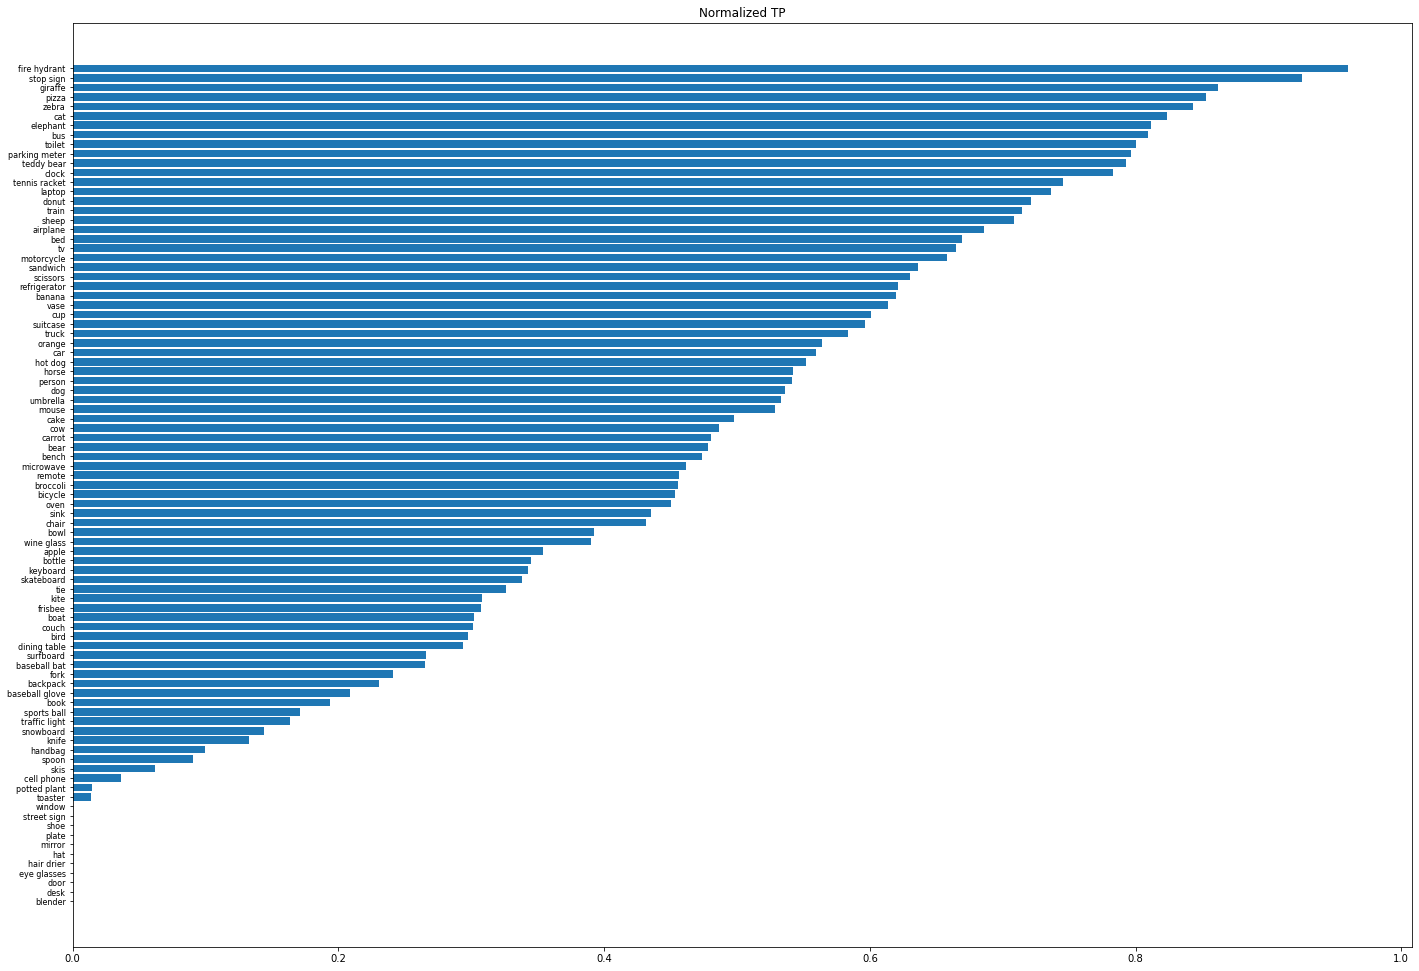

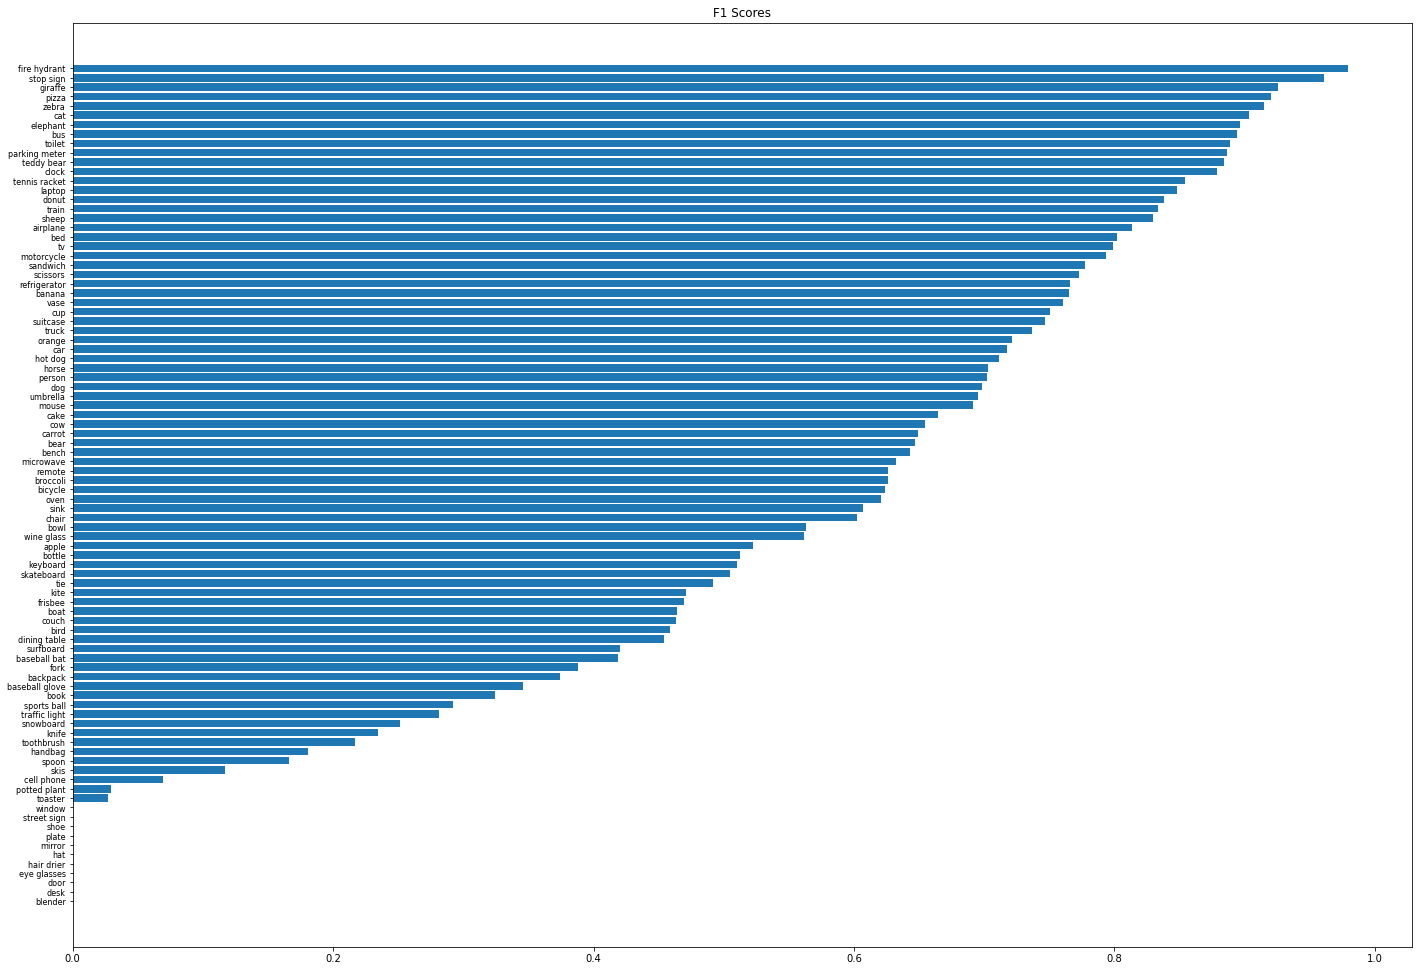

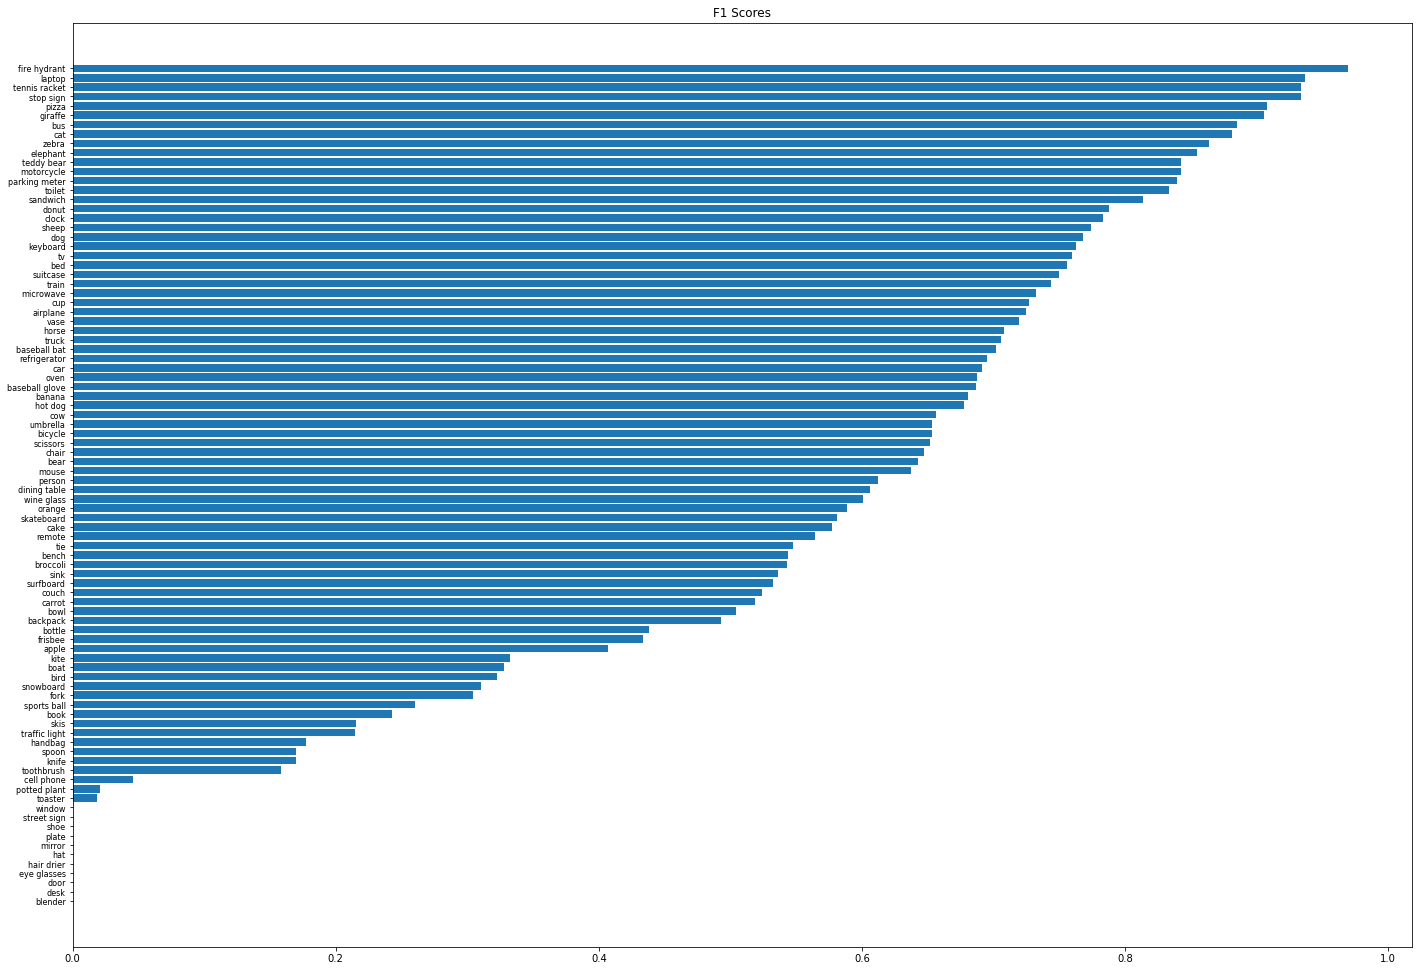

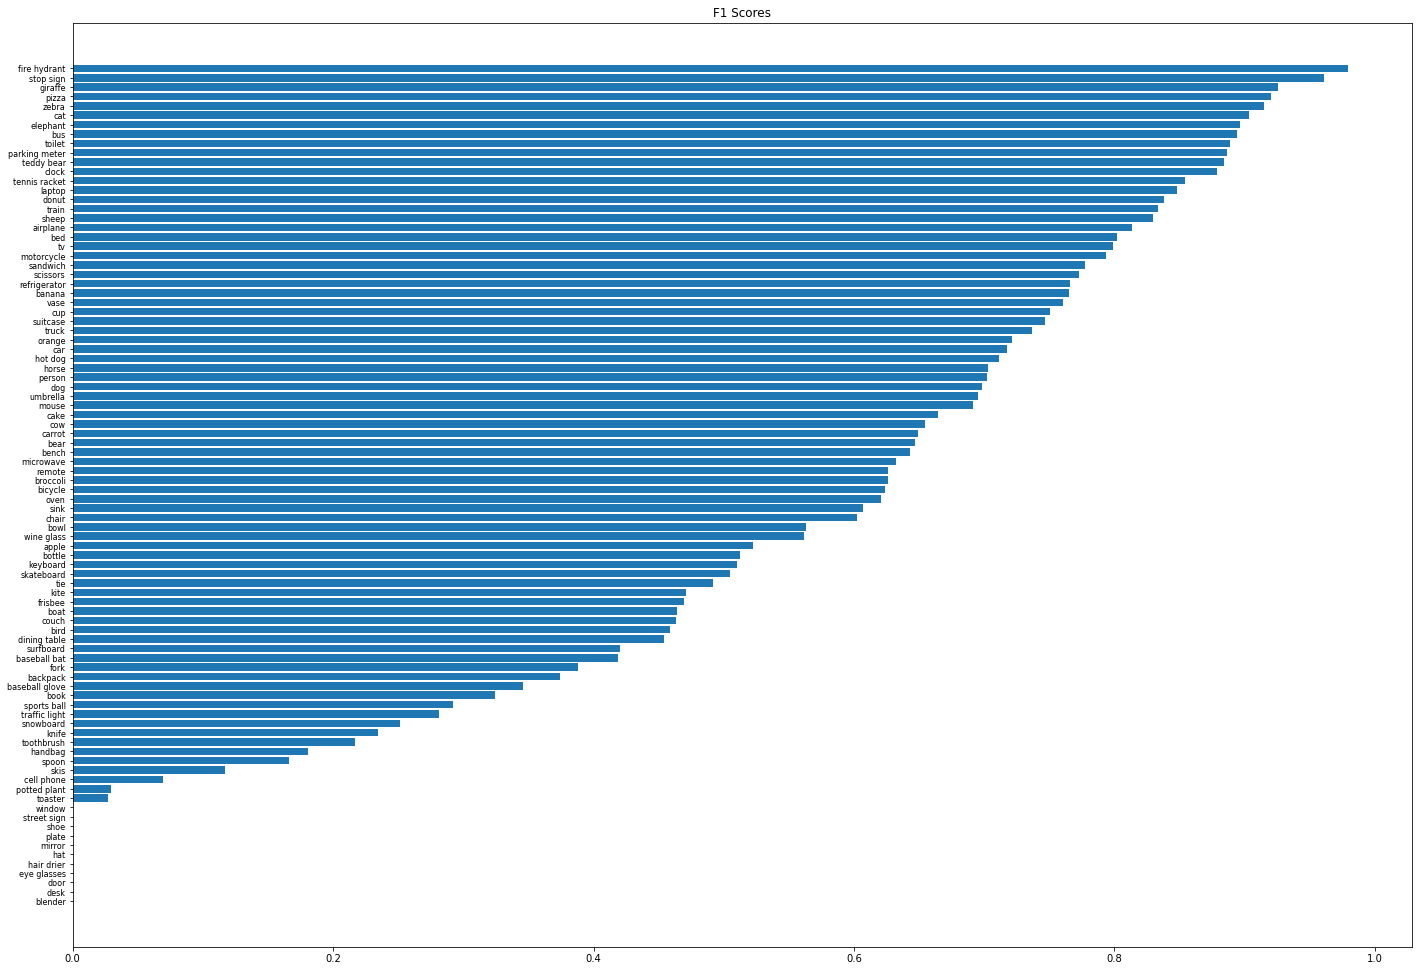

In [43]:
def open_matrix(filename='outfile_kuba.txt'):
    with open(filename, 'r') as f:
        l = [[int(float(num)) for num in line.split(' ')] for line in f]
    return l

confusion_matrix = open_matrix()
confusion_matrix = confusion_matrix[:-1]
draw_graphs('nic','0','0')

<ipython-input-38-1a93c2779df0>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename, papertype='a2')


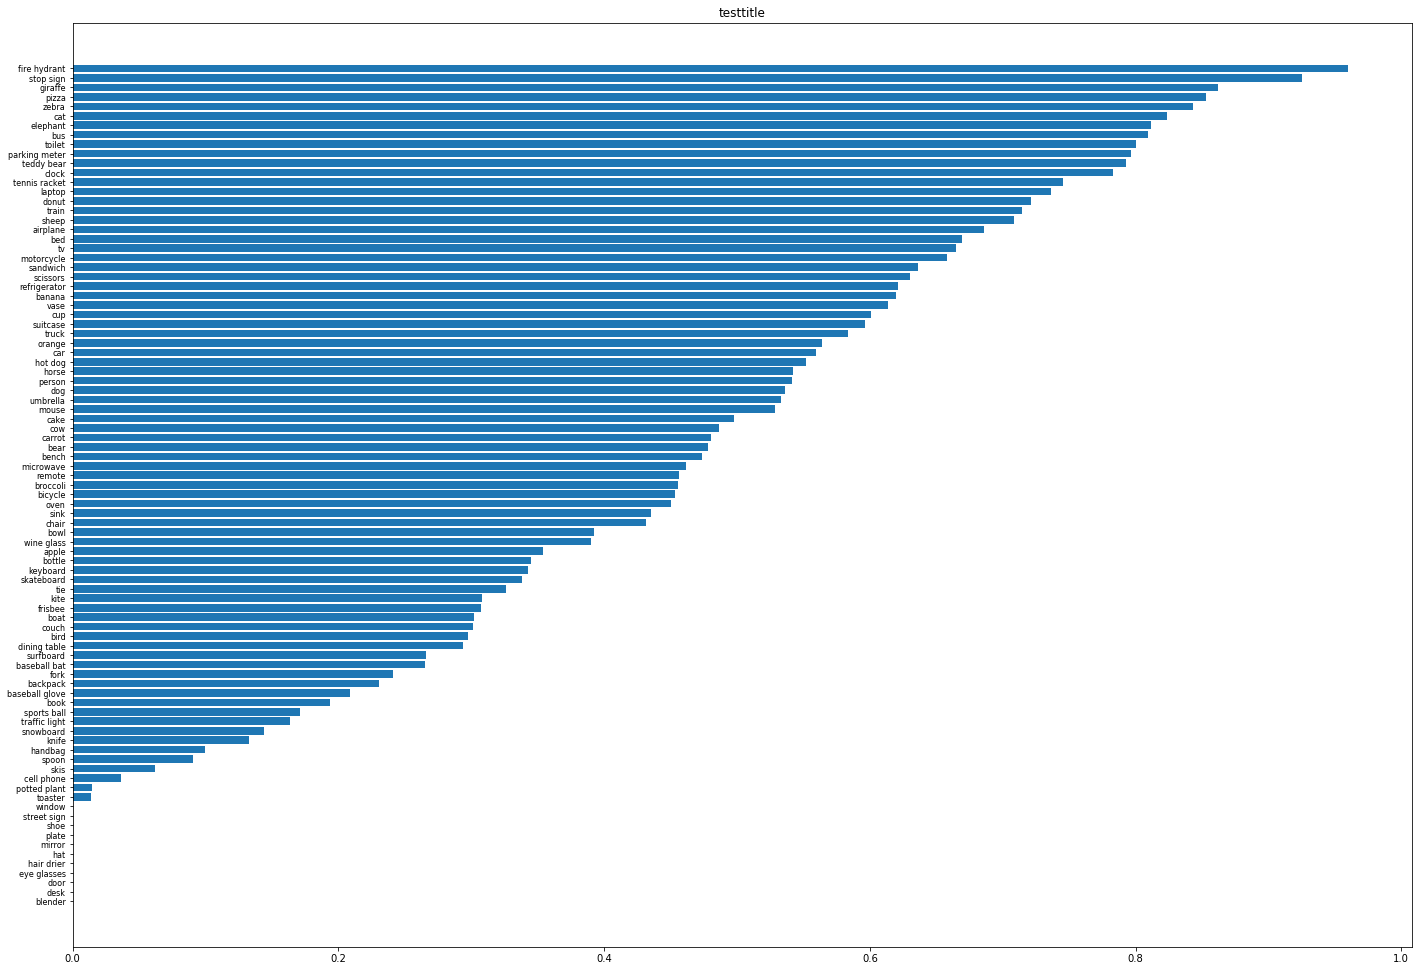

In [38]:

def draw_bar_chart(values, labels, title, filename):
    _values, _labels = zip(*sorted(zip(values, labels)))
    positions = np.arange(len(_values)) + 0.5
    plt.figure(num=None, figsize=(24, 17))
    plt.barh(positions, _values, align='center')
    plt.yticks(positions, _labels)
    plt.tick_params(axis='y', labelsize=8)
    plt.xlabel('')
    plt.title(title)
    # ax = plt.axes()
    # print(ax)
    # ax.xaxis.grid(True)
    plt.savefig(filename, papertype='a2')

tmp = []
for row in confusion_matrix:
    normalized_row = []
    for value in row:
        normalized_row.append(value/(sum(row)))
    tmp.append(normalized_row)


diag = [ tmp[i][i] for i in range(len(tmp)) ]
diag = diag[:-1]

coco = list(get_coco_labels().values())


draw_bar_chart(diag, coco, 'testtitle','fun_test.pdf');

